# Train and Optimize

Train a neural network on Treehouse gene expression to classify disease

In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf

print("Tensorflow version", tf.__version__)

# fix random seed for reproducibility
np.random.seed(42)

os.chdir(os.path.expanduser("~/data/treehouse"))

Tensorflow version 2.0.0-beta0


## Load and Wrangle Data

In [4]:
X = pd.read_hdf(os.path.expanduser("treehouse-pruned.h5"), "samples")
Y = pd.read_hdf(os.path.expanduser("treehouse-pruned.h5"), "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loaded 10208 samples with 5545 features and 4 labels


In [10]:
# Create a multi-label one-hot for tumor/normal and primary site
from sklearn.preprocessing import LabelEncoder

disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["disease"]), index=Y.index, dtype='int32')

Y_onehot = tf.keras.utils.to_categorical(Y["disease_value"])

In [11]:
# Split into training and test sets strattified on disease
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X.values, Y.disease_value):
    X_train = X.values[train_index]
    X_test = X.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    Y_onehot_train = Y_onehot[train_index]
    Y_onehot_test = Y_onehot[test_index]
    
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (8166, 5545) Test: (2042, 5545)


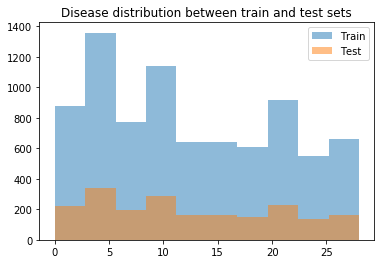

In [13]:
import matplotlib.pyplot as plt

# Lets see how big each class is based on primary site
plt.hist(Y_train.disease_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.disease_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test sets")
plt.show()

## Build and Train Model

In [15]:
def create_model(input_shape, output_shape, params):
    inputs = tf.keras.layers.Input(shape=(input_shape,))

    x = tf.keras.layers.BatchNormalization()(inputs)

    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(output_shape, activation="sigmoid")(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    return model

model = create_model(X_train.shape[1], Y_onehot_train.shape[1], {})
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="acc", min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, Y_onehot_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, Y_onehot_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5545)]            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5545)              22180     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                177472    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 29)                957 

In [17]:
# Save the model to disk so we can load, evaluate, infer and explain independantly
with open("params.json", "w") as f:
    f.write(json.dumps({
        "disease": primary_site_encoder.classes_.tolist(),
        "train_indices": train_index.tolist(),
        "test_indices": test_index.tolist()}))
    
model.save("model.h5")